<a href="https://colab.research.google.com/github/sznajder/Notebooks/blob/master/JetTagging_MLP_TFKeras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep MLP for Jet-Images
Author: Andre Sznajder

In [ ]:
#!fusermount -u drive
! pip install einops

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
data_dir = '/content/gdrive/My Drive/Colab Notebooks/Data/'

Mounted at /content/gdrive


## Load numpy arrays
Here, we load the numpy arrays containing the 4D tensors of "jet-images" (see https://arxiv.org/pdf/1511.05190.pdf)

In [ ]:
import h5py

h5f = h5py.File(data_dir+"jet_images.h5", "r")

jet_images_dict = {}
jet_images_dict['QCD'] = h5f['QCD'][()]
jet_images_dict['TT'] = h5f['TT'][()]

h5f.close()

In [ ]:
# 4D tensor (tensorflow backend)
# 1st dim is jet index
# 2nd dim is eta bin
# 3rd dim is phi bin
# 4th dim is pt value (or rgb values, etc.)
print(jet_images_dict['QCD'].ndim)
njet_qcd = jet_images_dict['QCD'].shape[0]
njet_tt = jet_images_dict['TT'].shape[0]
neta = jet_images_dict['TT'].shape[1]
nphi = jet_images_dict['TT'].shape[2]
npt = jet_images_dict['TT'].shape[3]
print('Number of QCD jets=',njet_qcd)
print('Number of TT jets=',njet_tt)
print('Number of Phi bins=',nphi)
print('Number of Eta bins=',neta)
print('Number of Pt bins=',npt)

4
Number of QCD jets= 3305
Number of TT jets= 1821
Number of Phi bins= 30
Number of Eta bins= 30
Number of Pt bins= 1


## Plotting jet-images
Let's plot some jet-images (individual jets and averaged over all jets)

**Question 1:**  Try to plot the average W and QCD jet-images.

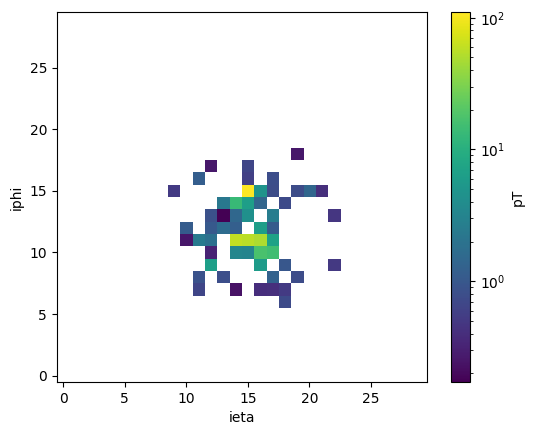

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
%matplotlib inline
plt.style.use('default')

# plot one W jet
i = 7
plt.figure('W') 
plt.imshow(jet_images_dict['TT'][i,:,:,0].T, norm=mpl.colors.LogNorm(), origin='lower', interpolation='none')
cbar = plt.colorbar()
cbar.set_label('pT')
plt.xlabel('ieta')
plt.ylabel('iphi')
plt.show()

# plot average W jet

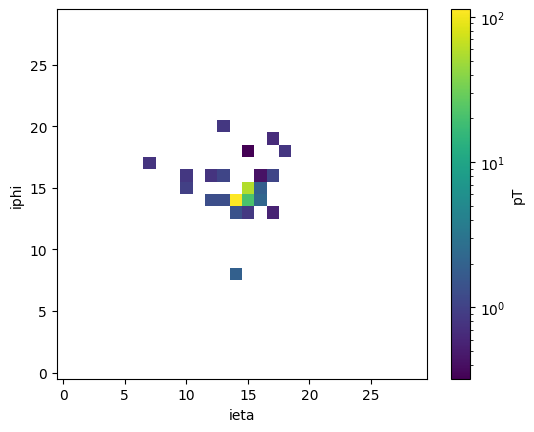

In [ ]:
# plot one QCD jet
i = 7
plt.figure() 
plt.imshow(jet_images_dict['QCD'][i,:,:,0].T, norm=mpl.colors.LogNorm(), origin='lower', interpolation='none')
cbar = plt.colorbar()
cbar.set_label('pT')
plt.xlabel('ieta')
plt.ylabel('iphi')
plt.show()

# plot average QCD jet

## Define our Deep MLP model
**Question 2:** Here we have a relatively simple `Conv2D` model using regularization, batch normalization, max pooling, and a fully connected layer before the ouput. Implement the network defined in https://arxiv.org/pdf/1511.05190.pdf. Compare the performance and number of parameters when using fully connected layers instead of convolutional layers.

In [ ]:
# baseline keras model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Input, Activation, Dense, Dropout
from tensorflow.keras import utils


# Define MLP input layer dimension ( NINPUT = neta*nphi )
NINPUT = neta*nphi*npt 

'''
input  = Input(shape=(NINPUT,), name = 'input') 
hidden = Dense(NINPUT/10 , name = 'hidden', kernel_initializer='normal', activation='relu')(input)
hidden = Dropout(rate=0.05)(hidden)
output  = Dense(1 , name = 'output', kernel_initializer='normal', activation='sigmoid')(hidden)
'''


# Define NN with 2 hidden layers ( #h1=10*NINPUT , #h2=3*NINPUT )
input  = Input(shape=(NINPUT,), name = 'input') 
hidden = Dense(NINPUT/10 , name = 'hidden1', kernel_initializer='normal', activation='relu')(input)
hidden = Dropout(rate=0.05)(hidden)
hidden = Dense(NINPUT/100 , name = 'hidden2', kernel_initializer='normal', activation='relu')(hidden)
hidden = Dropout(rate=0.05)(hidden)
output  = Dense(1      , name = 'output', kernel_initializer='normal', activation='sigmoid')(hidden)


'''
# Define NN with 3 hidden layers ( #h1=10*NINPUT , #h2=2*NINPUT , #h2=NINPUT ) & Dropout
input  = Input(shape=(NINPUT,), name = 'input') 
hidden = Dense(NINPUT/10, name = 'hidden1', kernel_initializer='normal', activation='relu')(input)
hidden = Dropout(rate=0.05)(hidden)
hidden = Dense(NINPUT/50 , name = 'hidden2', kernel_initializer='normal', activation='relu')(hidden)
hidden = Dropout(rate=0.05)(hidden)
hidden = Dense(NINPUT/100   , name = 'hidden3', kernel_initializer='normal', activation='relu')(hidden)
hidden = Dropout(rate=0.05)(hidden)
output  = Dense(1       , name = 'output', kernel_initializer='normal', activation='sigmoid')(hidden)
'''

# create the model
mlp = Model(inputs=input, outputs=output)
# Define the optimizer ( minimization algorithm )
#optim = SGD(lr=0.01,decay=1e-6)
#optim = Adam(lr=0.001)
optim = Adam()

# compile the model
#mlp.compile(optimizer=optim, loss='mean_squared_error', metrics=['accuracy'], weighted_metrics=['accuracy'])
#mlp.compile(optimizer=optim, loss='mean_squared_error', metrics=['accuracy'])
mlp.compile(optimizer=optim, loss='binary_crossentropy', metrics=['accuracy'], weighted_metrics=['accuracy'])
# print the model summary
mlp.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 900)]             0         
_________________________________________________________________
hidden1 (Dense)              (None, 90)                81090     
_________________________________________________________________
dropout (Dropout)            (None, 90)                0         
_________________________________________________________________
hidden2 (Dense)              (None, 9)                 819       
_________________________________________________________________
dropout_1 (Dropout)          (None, 9)                 0         
_________________________________________________________________
output (Dense)               (None, 1)                 10        
Total params: 81,919
Trainable params: 81,919
Non-trainable params: 0
_________________________________________________________

## Dividing the data into testing and training dataset

We will split the data into two parts (one for training+validation and one for testing) and use early stoppping regularization.


In [ ]:
from einops import rearrange, reduce, repeat
jet_images = np.concatenate( [ jet_images_dict['TT'], jet_images_dict['QCD'] ] )
jet_images = rearrange( jet_images , 'batch eta phi pt -> batch (eta phi pt)' )  
#jet_images = jet_images.reshape( len(jet_images),jet_images.shape[1]*jet_images.shape[2])
jet_labels = np.concatenate( [ np.ones(njet_tt), np.zeros(njet_qcd) ] )

print(jet_images.shape)

X = jet_images
Y = jet_labels

from sklearn.model_selection import train_test_split
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.2, random_state=7)
#X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.2, random_state=7, shuffle=True)

print('number of W jets for training/validation: %i'%np.sum(Y_train_val==1))
print('number of QCD jets for training/validation: %i'%np.sum(Y_train_val==0))

print('number of W jets for testing: %i'%np.sum(Y_test==1))
print('number of QCD jets for testing: %i'%np.sum(Y_test==0))



(5126, 900)
number of W jets for training/validation: 1459
number of QCD jets for training/validation: 2641
number of W jets for testing: 362
number of QCD jets for testing: 664


## Run training
Here, we run the training.

In [ ]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

# early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# model checkpoint callback
# this saves our model architecture + parameters into mlp_model.h5
model_checkpoint = ModelCheckpoint('mlp_model.h5', monitor='val_loss', 
                                   verbose=0, save_best_only=True, 
                                   save_weights_only=False, mode='auto', 
                                   period=1)

# Train classifier
history = mlp.fit(  X_train_val, Y_train_val, 
                    epochs=100, 
                    batch_size=512, 
                    verbose=1,
                    callbacks=[early_stopping, model_checkpoint], 
                    validation_split=0.25 )
                    
#                    callbacks=[early_stopping, model_checkpoint], 
                    

Epoch 1/100
7/7 [==============================] - 1s 64ms/step - loss: 0.6302 - accuracy: 0.6454 - weighted_accuracy: 0.6454 - val_loss: 0.5440 - val_accuracy: 0.6410 - val_weighted_accuracy: 0.6410
Epoch 2/100
7/7 [==============================] - 0s 9ms/step - loss: 0.5202 - accuracy: 0.6487 - weighted_accuracy: 0.6487 - val_loss: 0.4805 - val_accuracy: 0.6439 - val_weighted_accuracy: 0.6439
Epoch 3/100
7/7 [==============================] - 0s 9ms/step - loss: 0.4670 - accuracy: 0.6567 - weighted_accuracy: 0.6567 - val_loss: 0.4354 - val_accuracy: 0.7054 - val_weighted_accuracy: 0.7054
Epoch 4/100
7/7 [==============================] - 0s 11ms/step - loss: 0.4284 - accuracy: 0.7246 - weighted_accuracy: 0.7246 - val_loss: 0.4028 - val_accuracy: 0.8215 - val_weighted_accuracy: 0.8215
Epoch 5/100
7/7 [==============================] - 0s 9ms/step - loss: 0.3864 - accuracy: 0.8283 - weighted_accuracy: 0.8283 - val_loss: 0.3755 - val_accuracy: 0.8654 - val_weighted_accuracy: 0.8654
Epo

## Plot performance
Here, we plot the history of the training and the performance in a ROC curve

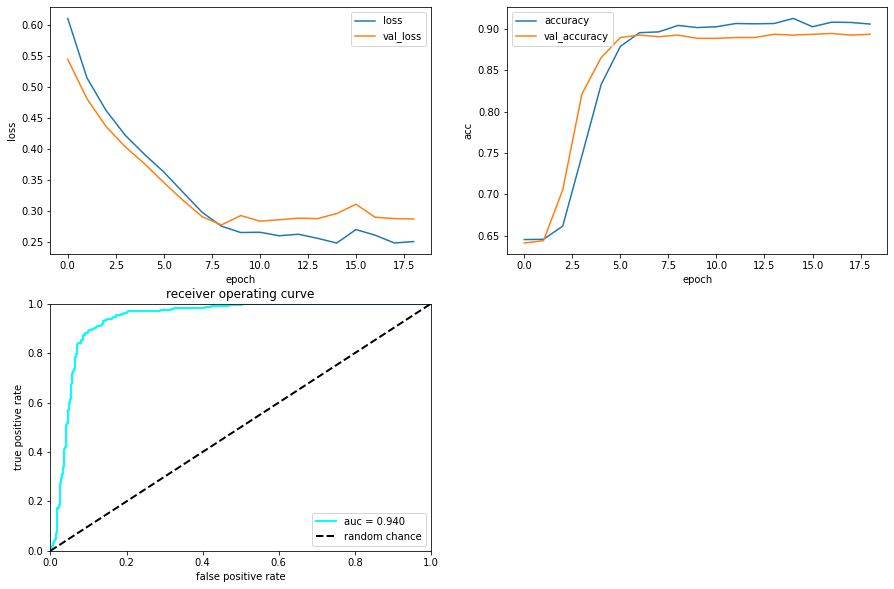

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
#
# Plot loss vs epoch
plt.figure(figsize=(15,10))
ax = plt.subplot(2, 2, 1)
ax.plot(history.history['loss'], label='loss')
ax.plot(history.history['val_loss'], label='val_loss')
ax.legend(loc="upper right")
ax.set_xlabel('epoch')
ax.set_ylabel('loss')

# Plot accuracy vs epoch
ax = plt.subplot(2, 2, 2)
ax.plot(history.history['accuracy'], label='accuracy')
ax.plot(history.history['val_accuracy'], label='val_accuracy')
ax.legend(loc="upper left")
ax.set_xlabel('epoch')
ax.set_ylabel('acc')

# Plot ROC
Y_predict = mlp.predict(X_test)
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(Y_test, Y_predict)
roc_auc = auc(fpr, tpr)
ax = plt.subplot(2, 2, 3)
ax.plot(fpr, tpr, lw=2, color='cyan', label='auc = %.3f' % (roc_auc))
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='random chance')
ax.set_xlim([0, 1.0])
ax.set_ylim([0, 1.0])
ax.set_xlabel('false positive rate')
ax.set_ylabel('true positive rate')
ax.set_title('receiver operating curve')
ax.legend(loc="lower right")
plt.show()

In [ ]:
# Plot DNN output 
df_sig  = df['sig'].filter(NN_VARS)
df_bkg  = df['bkg'].filter(NN_VARS)

X_sig  = np.asarray( df_sig.values ).astype(np.float32)
X_bkg  = np.asarray( df_bkg.values ).astype(np.float32)

Y_sig = model.predict(X_sig)
Y_bkg = model.predict(X_bkg)

ax = plt.subplot(3, 2, 4)
X = np.linspace(0.0, 1.0, 100)
hist_sig = ax.hist(Y_sig, bins=X, label='sig',histtype='step',lw=LINE_WIDTH)
hist_bkg = ax.hist(Y_bkg, bins=X, label='bkg',histtype='step',lw=LINE_WIDTH)
#ax.hist(Y_train_val, bins=X, label='bkg',histtype='step')
ax.set_xlabel('DNN Output')
ax.legend(prop={'size': 10})


# Plot Eff x Purity

ax = plt.subplot(3, 2, 5)
ax.plot(t, p[:-1], label='purity', lw=LINE_WIDTH)
ax.plot(t, r[:-1], label='efficiency', lw=LINE_WIDTH)
ax.set_xlabel('Cut on model score')
ax.tick_params(width=2, grid_alpha=0.5)
ax.legend()

ax = plt.subplot(3, 2, 6)
ax.plot(t,p[:-1]*r[:-1], lw=LINE_WIDTH)
ax.set_xlabel('Cut on model score')
ax.set_ylabel('Purity*Efficiency')
ax.tick_params(width=2, grid_alpha=0.5)

# Show plots
plt.show()

NameError: ignored